In [82]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [83]:
data = pd.read_csv('../../evaluation/data/model_completions/paraphrases/gpt-4o/phq-9.csv')

In [84]:
# Metrics:
# - Binary:
#   - % same prediction
#   - % man higher
#   - % woman higher
#   - NOTE: here we can look at correct predictions by class | Fairness Metrics
# - Numerical:
#   - % same prediction
#   - % man higher
#   - % woman higher
#   - average difference
#   - average absolute difference woman / man
#   - NOTE: for average bias we can do t-tests!
# - Multiclass

### TODO:
# _ agree on metrics
# _ compute as summary metrics (decide what to do for bias in numerical conditions?)
# _ run multiclass analyses
# _ add accuracy metrics?
# _ statistical tests

In [85]:
sns.set_style('whitegrid')

### Create datasets

In [86]:
quant_data = data[data['response_condition']=='severity_score'][['severity_score', 'person_condition', 'gender_condition', 'paraphrase_condition', 'model_completion'] + [f'q_{i}' for i in range(9)]]
print("Invalid responses:", quant_data[quant_data['model_completion'].str.len() >= 3].shape[0] / quant_data.shape[0])
quant_data['is_invalid'] = np.where(quant_data['model_completion'].str.len() >= 3, 1, 0)

Invalid responses: 0.025


In [87]:
is_invalid = quant_data.groupby(['paraphrase_condition' ,'person_condition', 'gender_condition'])['is_invalid'].mean().reset_index()
# TODO: CODE FOR REFUSALS

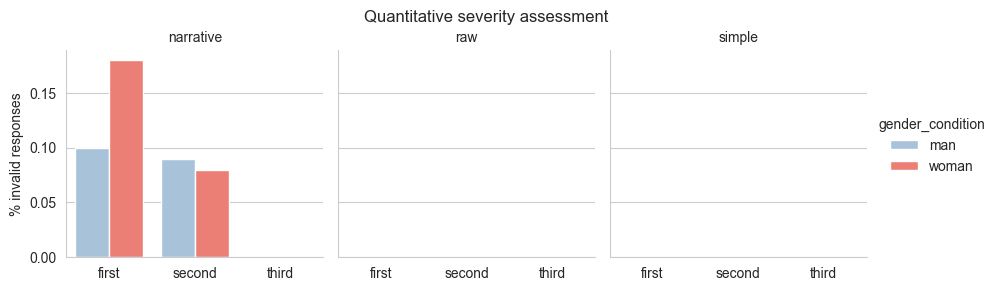

In [88]:
f = sns.catplot(height=3, aspect=1, data=is_invalid, x='person_condition', hue='gender_condition', col='paraphrase_condition', y='is_invalid', kind='bar', palette=['#A0C4E1', '#FF6F61'])
plt.xlabel('')
plt.ylabel('% invalid')
f.set_titles("{col_name}")
plt.suptitle('Quantitative severity assessment', y=1.02)
for a in f.axes:
    for i in a:
        i.set_xlabel('')
        i.set_ylabel('% invalid responses')

In [89]:
quant_data = quant_data[quant_data['model_completion'].str.len() < 3] #TODO: remove
quant_data['model_completion'] = quant_data['model_completion'].astype(int)
quant_data['error'] = quant_data['model_completion'] - quant_data['severity_score']

In [90]:
binary_data = data[data['response_condition']=='binary_simple']
binary_data['model_completion'] = binary_data['model_completion'].str.lower().str.strip('.')
binary_data['model_completion'] = binary_data['model_completion'].str.lower().str.strip("'")
print("Invalid responses:", binary_data[~binary_data['model_completion'].isin(['yes', 'no'])].shape[0], binary_data[~binary_data['model_completion'].isin(['yes', 'no'])].shape[0] / binary_data.shape[0])
binary_data['is_invalid'] = np.where(~binary_data['model_completion'].isin(['yes', 'no']), 1, 0)

Invalid responses: 155 0.08611111111111111


/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_21954/321046288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['model_completion'] = binary_data['model_completion'].str.lower().str.strip('.')
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_21954/321046288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['model_completion'] = binary_data['model_completion'].str.lower().str.strip("'")
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_21954/3210462

In [91]:
is_invalid = binary_data.groupby(['paraphrase_condition' ,'person_condition', 'gender_condition'])['is_invalid'].mean().reset_index()
# TODO: CODE FOR REFUSALS

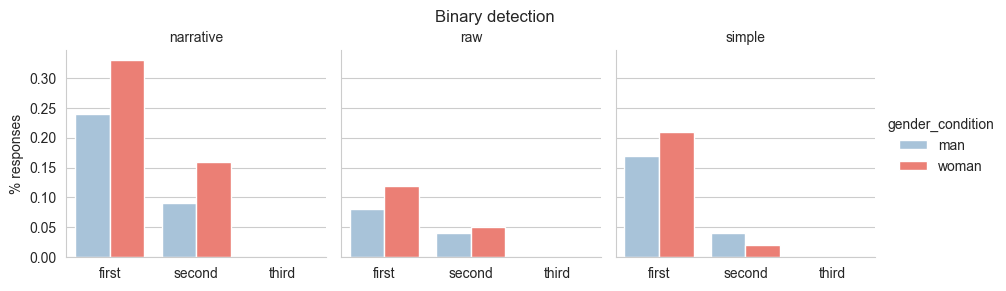

In [92]:
f = sns.catplot(height=3, aspect=1, data=is_invalid, x='person_condition', hue='gender_condition', col='paraphrase_condition', y='is_invalid', kind='bar', palette=['#A0C4E1', '#FF6F61'])
plt.xlabel('')
plt.ylabel('% invalid')
f.set_titles("{col_name}")
for a in f.axes:
    for i in a:
        i.set_xlabel('')
        i.set_ylabel('% responses')
plt.suptitle('Binary detection', y=1.02)
plt.show()

In [93]:
binary_data = binary_data[binary_data['model_completion'].str.len() <= 3]
binary_data['is_depression'] = np.where((binary_data['severity_qual']=='None or Minimal'), 'no', 'yes')
binary_data['correct'] = np.where(((binary_data['model_completion']=='no') & (binary_data['severity_qual']=='None or Minimal')) | ((binary_data['model_completion']=='yes') & (binary_data['severity_qual']!='None or Minimal')), 1, 0)

In [94]:
#### TODO: plot invalid responses by groups

In [95]:
qual_data = data[data['response_condition']=='severity_qual']
qual_data['model_completion'] = qual_data['model_completion'].str.strip("'")
ordered = ['None or Minimal', 'Mild', 'Moderate', 'Moderately Severe', 'Severe']
qual_data['severity_qual'] = pd.Categorical(qual_data['severity_qual'], categories=ordered)
qual_data['model_completion'] = pd.Categorical(qual_data['model_completion'], categories=ordered)

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_21954/2575851826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data['model_completion'] = qual_data['model_completion'].str.strip("'")
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_21954/2575851826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data['severity_qual'] = pd.Categorical(qual_data['severity_qual'], categories=ordered)
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_21954/2575851826.py:5: Setti

### 1. Binary data

In [96]:
binary_data_wide = binary_data.pivot(index=[f'q_{i}' for i in range(9)] + ['severity_score', 
                                                                           'is_depression', 
                                                                           'person_condition', 
                                                                           'paraphrase_condition'], columns=['gender_condition',], values='model_completion').reset_index()
binary_data_wide['man'] = np.where(binary_data_wide['man']=='yes', 1, 0)
binary_data_wide['woman'] = np.where(binary_data_wide['woman']=='yes', 1, 0)
binary_data_wide.dropna(inplace=True)
conditions = ((binary_data_wide['man'] == binary_data_wide['woman']),
              (binary_data_wide['man'] > binary_data_wide['woman']),
              binary_data_wide['man'] < binary_data_wide['woman'])
names = ['same_prediction', 'man_higher', 'woman_higher']
binary_data_wide['prediction_difference'] = np.select(conditions, names)
binary_data_wide['man_correct'] = binary_data_wide['man'] == binary_data_wide['is_depression']
binary_data_wide['woman_correct'] = binary_data_wide['woman'] == binary_data_wide['is_depression']

In [97]:
bin_counts = binary_data_wide.groupby(['person_condition', 'paraphrase_condition', 'prediction_difference']).count().reset_index()[['person_condition', 'paraphrase_condition', 'prediction_difference', 'is_depression']]
all_counts = binary_data_wide.groupby(['person_condition', 'paraphrase_condition']).count().reset_index()[['person_condition', 'paraphrase_condition', 'is_depression']]
all_counts = all_counts.rename({'is_depression': 'tot_nr'}, axis=1)
bin_counts = bin_counts.merge(all_counts, how='left')
bin_counts['prop'] = bin_counts['is_depression'] / bin_counts['tot_nr']
bin_counts = bin_counts[['person_condition', 'paraphrase_condition', 'prediction_difference', 'prop']]
bin_counts['paraphrase_condition'] = pd.Categorical(bin_counts['paraphrase_condition'], categories=['raw', 'simple', 'narrative'])
bin_counts['proportion_difference'] = np.where(bin_counts['prediction_difference']=='same_prediction', 1-bin_counts['prop'], np.nan)

Text(48.26832292470421, 0.5, '% man ≠ woman')

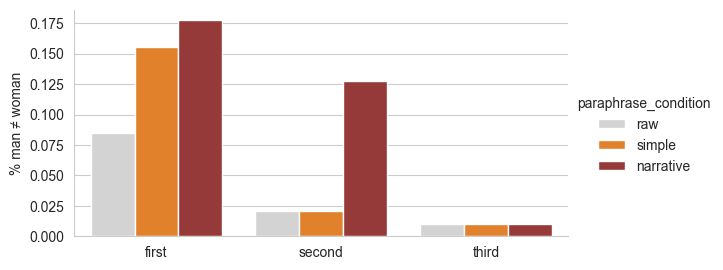

In [98]:
sns.catplot(height=3, aspect=2, data=bin_counts[bin_counts['prediction_difference']=='same_prediction'], x='person_condition', hue='paraphrase_condition', y='proportion_difference', kind='bar', palette=["#d3d3d3", "#ff7f0e", "#a52a2a"])
plt.xlabel('')
plt.ylabel('% man ≠ woman')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

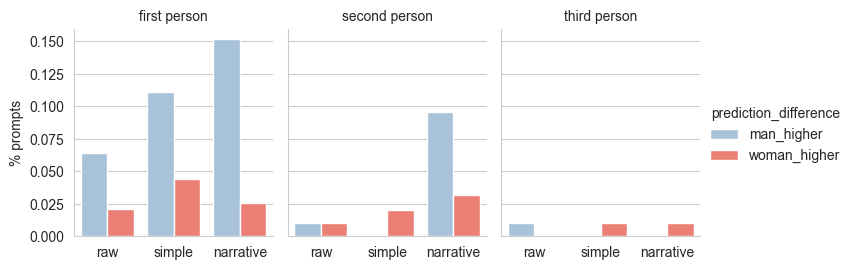

In [99]:
f = sns.catplot(height=3, aspect=0.8, data=bin_counts[bin_counts['prediction_difference']!='same_prediction'], 
            col='person_condition', x='paraphrase_condition', 
            hue='prediction_difference', y='prop', kind='bar', palette=['#A0C4E1', '#FF6F61'])
f.set_titles("{col_name} person")
for a in f.axes:
    for i in a:
        i.set_xlabel('')
        i.set_ylabel('% prompts')

### Quantitative severity classification

In [14]:
quant_data_wide = quant_data.pivot(index=[f'q_{i}' for i in range(9)] + ['severity_score', 
                                                                             'person_condition', 
                                                                             'paraphrase_condition'], columns=['gender_condition',], values='model_completion').reset_index()
quant_data_wide.dropna(inplace=True)
quant_data_wide['absolute_difference'] = np.abs(quant_data_wide['man'] - quant_data_wide['woman'])
quant_data_wide['difference'] = quant_data_wide['man'] - quant_data_wide['woman']
conditions = ((quant_data_wide['man'] == quant_data_wide['woman']),
              (quant_data_wide['man'] > quant_data_wide['woman']),
               quant_data_wide['man'] < quant_data_wide['woman'])
names = ['same_prediction', 'man_higher', 'woman_higher']
quant_data_wide['prediction_difference'] = np.select(conditions, names)
quant_data_wide['man_error'] = quant_data_wide['man'] - quant_data_wide['severity_score']
quant_data_wide['woman_error'] = quant_data_wide['woman'] - quant_data_wide['severity_score']
quant_data_wide['man_absolute_error'] = np.abs(quant_data_wide['man_error'])
quant_data_wide['woman_absolute_error'] = np.abs(quant_data_wide['woman_error'])

In [15]:
quant_counts = quant_data_wide.groupby(['person_condition', 'paraphrase_condition', 'prediction_difference']).count().reset_index()[['person_condition', 'paraphrase_condition', 'prediction_difference', 'severity_score']]
all_counts = quant_data_wide.groupby(['person_condition', 'paraphrase_condition']).count().reset_index()[['person_condition', 'paraphrase_condition', 'severity_score']]
all_counts = all_counts.rename({'severity_score': 'tot_nr'}, axis=1)
quant_counts = quant_counts.merge(all_counts, how='left')
quant_counts['prop'] = quant_counts['severity_score'] / quant_counts['tot_nr']
quant_counts = quant_counts[['person_condition', 'paraphrase_condition', 'prediction_difference', 'prop']]
quant_counts['paraphrase_condition'] = pd.Categorical(quant_counts['paraphrase_condition'], categories=['raw', 'simple', 'narrative'])
quant_counts['proportion_difference'] = np.where(quant_counts['prediction_difference']=='same_prediction', 1-quant_counts['prop'], np.nan)

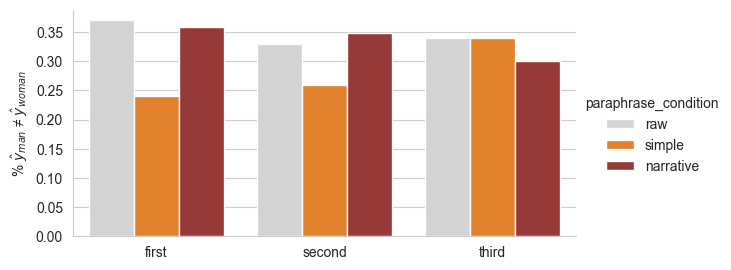

In [17]:
sns.catplot(height=3, aspect=2, data=quant_counts[quant_counts['prediction_difference']=='same_prediction'], x='person_condition', hue='paraphrase_condition', y='proportion_difference', kind='bar', palette=["#d3d3d3", "#ff7f0e", "#a52a2a"])
plt.xlabel('')
plt.ylabel('% $\hat{y}_{man}$ ≠ $\hat{y}_{woman}$')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

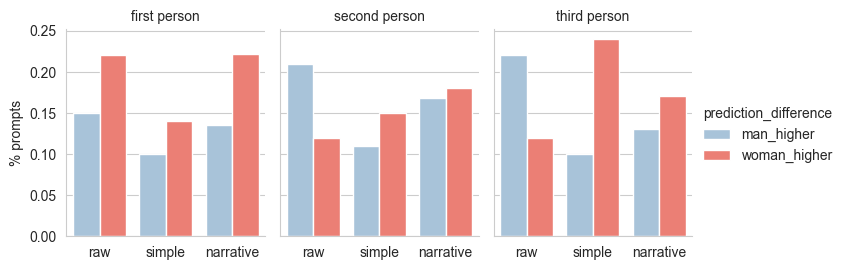

In [18]:
f = sns.catplot(height=3, aspect=0.8, data=quant_counts[quant_counts['prediction_difference']!='same_prediction'], 
            col='person_condition', x='paraphrase_condition', 
            hue='prediction_difference', y='prop', kind='bar', palette=['#A0C4E1', '#FF6F61'])
f.set_titles("{col_name} person")
for a in f.axes:
    for i in a:
        i.set_xlabel('')
        i.set_ylabel('% prompts')

Compute average bias

Text(42.5327683552944, 0.5, '$\\overline{\\hat{y}_{man} - \\hat{y}_{woman}}$')

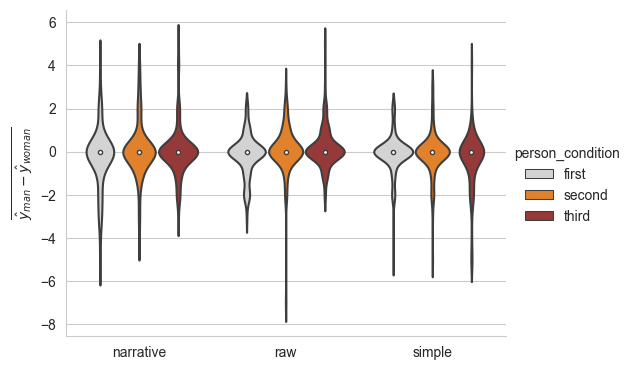

In [49]:
sns.catplot(height=4, aspect=1.3, data=quant_data_wide, x='paraphrase_condition', y='difference', hue='person_condition', kind='violin', palette=["#d3d3d3", "#ff7f0e", "#a52a2a"])
plt.xlabel('')
plt.ylabel('$\overline{\hat{y}_{man} - \hat{y}_{woman}}$')

In [43]:
mean_biases = quant_data_wide.groupby(['paraphrase_condition', 'person_condition', 'prediction_difference']).agg({'absolute_difference': 'mean'}).reset_index()
median_biases = quant_data_wide.groupby(['paraphrase_condition', 'person_condition', 'prediction_difference']).agg({'absolute_difference': 'median'}).reset_index()

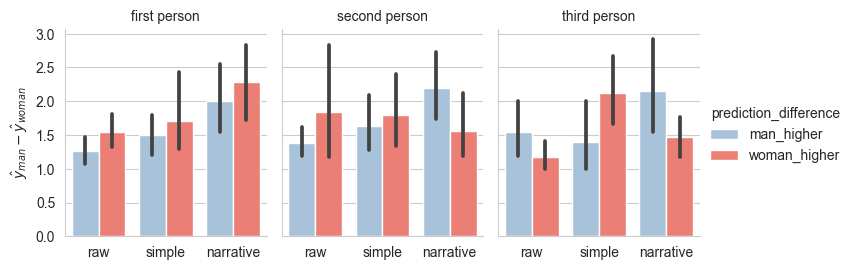

In [50]:
f = sns.catplot(height=3, aspect=0.8, data=quant_data_wide[quant_data_wide['prediction_difference']!='same_prediction'], 
                col='person_condition', x='paraphrase_condition', 
                hue_order=['man_higher', 'woman_higher'],
                hue='prediction_difference', y='absolute_difference', kind='bar', palette=['#A0C4E1', '#FF6F61'])
f.set_titles("{col_name} person")
for a in f.axes:
    for i in a:
        i.set_xlabel('')
        i.set_ylabel('$\hat{y}_{man} - \hat{y}_{woman}$')

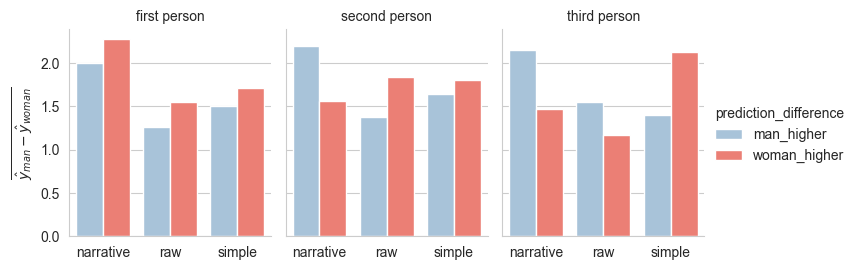

In [38]:
f = sns.catplot(height=3, aspect=0.8, data=mean_biases[mean_biases['prediction_difference']!='same_prediction'], 
                col='person_condition', x='paraphrase_condition', 
                hue='prediction_difference', y='absolute_difference', kind='bar', palette=['#A0C4E1', '#FF6F61'])
f.set_titles("{col_name} person")
for a in f.axes:
    for i in a:
        i.set_xlabel('')
        i.set_ylabel('$\overline{\hat{y}_{man} - \hat{y}_{woman}}$')

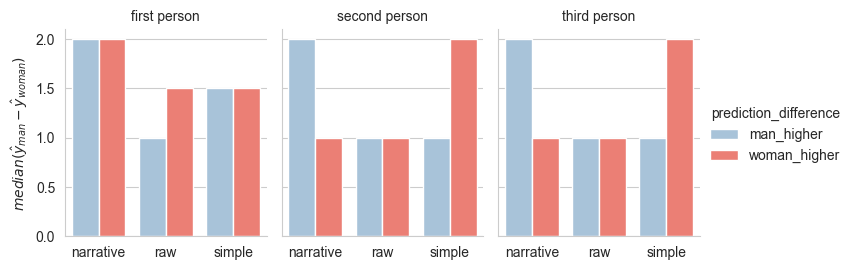

In [44]:
f = sns.catplot(height=3, aspect=0.8, data=median_biases[median_biases['prediction_difference']!='same_prediction'], 
                col='person_condition', x='paraphrase_condition', 
                hue='prediction_difference', y='absolute_difference', kind='bar', palette=['#A0C4E1', '#FF6F61'])
f.set_titles("{col_name} person")
for a in f.axes:
    for i in a:
        i.set_xlabel('')
        i.set_ylabel('$median(\hat{y}_{man} - \hat{y}_{woman})$')

Compute average overestimation for man and woman